In [ ]:
import pandas as pd # Importing requireq libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')

In [ ]:
exchange = pd.read_csv('/content/exchange_rate.csv') #Importing dataset
exchange

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


* The exchange_rate.csv file contains daily exchange rate data, starting from January 1st, 1990. The data likely represents the exchange rate between two currencies, allowing us to analyze trends in the value of one currency relative to the other over time.

In [ ]:
exchange.info() #Get information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
exchange['date'] = pd.to_datetime(exchange['date'],format='%d-%m-%Y %H:%M') # Convert the date column to datetime format

In [ ]:
exchange.info() #Check the data type of the date column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


In [ ]:
px.line(exchange,x='date',y='Ex_rate',template='plotly_dark') #ploting line plot

This time series plot shows the exchange rate trends over time. Let's analyze the key aspects:

**Trend:** There appears to be a general downward trend in the exchange rate over the entire period. The rate starts around 0.78-0.79 in 1990 and ends lower, around 0.70-0.72 in the later years.

**Seasonality:** From this high-level view, it's difficult to discern clear seasonal patterns. We would need to zoom in or perform additional analysis to identify any recurring seasonal fluctuations.

**Anomalies:**
There are several noticeable spikes and dips in the exchange rate:

* A significant drop around 1992-1993

* A sharp increase around 2008-2009, possibly related to the global financial crisis
* Another notable increase around 2016-2017

**Volatility:** The exchange rate appears to have periods of relative stability interspersed with periods of higher volatility. The volatility seems to increase in the latter part of the time series.

In [ ]:
exchange.isna().sum() #Check for missing values

,0
date,0
Ex_rate,0


In [ ]:
px.box(exchange['date']) #Check for outliers

* There is no any missing values or outliers in the data

In [ ]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Check for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\	{key}: {value}')

In [ ]:
print("Stationarity Test for Original Series:")
test_stationarity(exchange['Ex_rate'])

Stationarity Test for Original Series:
ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Critical Values:
\	1%: -3.4312123140180137
\	5%: -2.861921078147796
\	10%: -2.5669728434336108


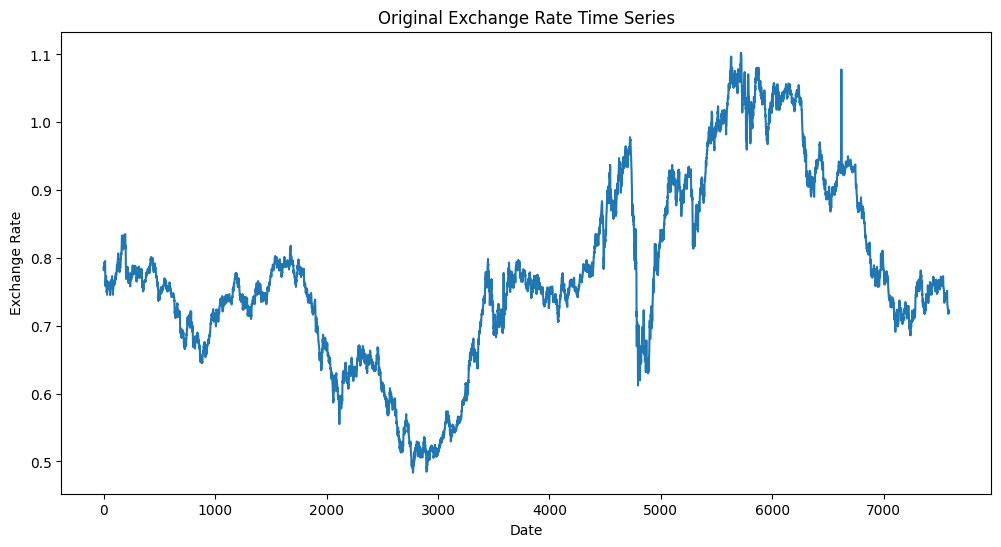

In [ ]:
# Plot original series
plt.figure(figsize=(12, 6))
plt.plot(exchange.index, exchange['Ex_rate'])
plt.title('Original Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.show()

In [ ]:
# Calculate first difference
exchange['first_difference'] = exchange['Ex_rate'].diff()

print("Stationarity Test for First Difference:")
exchange['first_difference'].dropna()

Stationarity Test for First Difference:


,first_difference
1,-0.003700
2,0.004900
3,-0.000700
4,-0.001100
5,0.001700
...,...
7583,-0.000207
7584,0.003345
7585,0.001358
7586,-0.002372


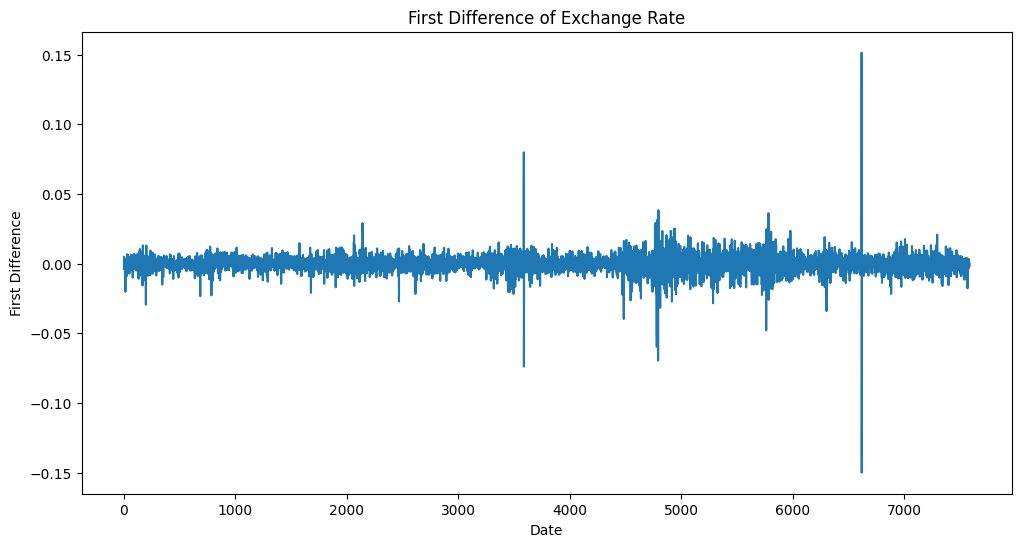

In [ ]:
# Plot first difference
plt.figure(figsize=(12, 6))
plt.plot(exchange.index[1:], exchange['first_difference'][1:])
plt.title('First Difference of Exchange Rate')
plt.xlabel('Date')
plt.ylabel('First Difference')
plt.show()

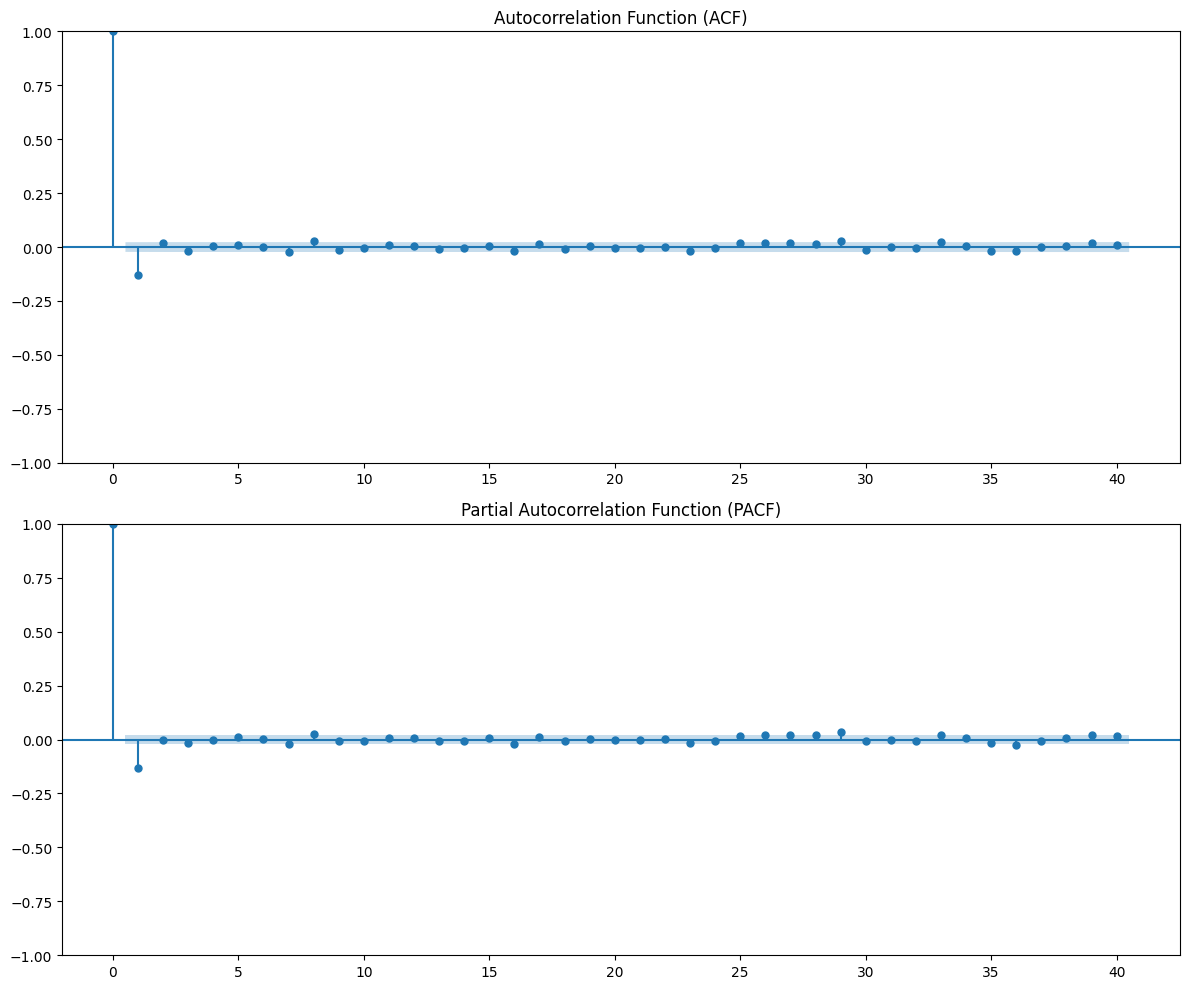

In [ ]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(exchange['first_difference'].dropna(), ax=ax1, lags=40)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(exchange['first_difference'].dropna(), ax=ax2, lags=40)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA # Importing requireq libraries
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.model_selection import train_test_split

In [ ]:
train_data, test_data = train_test_split(exchange['Ex_rate'], test_size=0.2, shuffle=False,random_state=42) # Splitting the data into train and test

In [ ]:
# Fit an ARIMA model with initial values of p=1, d=1, q=1
model = ARIMA(train_data, order=(1, 1, 1))
results = model.fit()

In [ ]:
# Perform Ljung-Box test for autocorrelation in the residuals
residuals = results.resid
lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)

In [ ]:
# Check the p-values to assess autocorrelation
for p_val_str in lb_test_p_value:
    if p_val_str != 'l' and p_val_str != 'b':
        # If a numeric p-value is found, break out of the loop
        break
    # Increase the order of the ARIMA model by incrementing p and q
    order = (order[0] + 1, 1, order[2] + 1)
    model = ARIMA(train_data, order=order)
    results = model.fit()

    # Perform Ljung-Box test again
    residuals = results.resid
    lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)

# Print the final order of the ARIMA model
print("Final order of ARIMA model (p, d, q):", order)

Final order of ARIMA model (p, d, q): (3, 1, 3)


In [ ]:
# Fit the ARIMA model
model = ARIMA(exchange['Ex_rate'], order=(3, 1, 3))
results = model.fit()

In [ ]:
# Diagnostics
residuals = results.resid

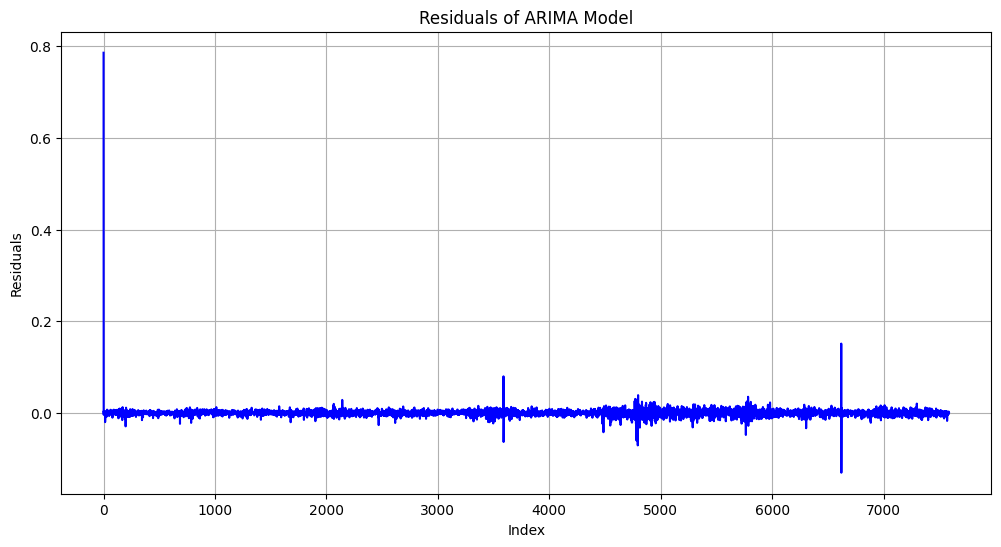

In [ ]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.title('Residuals of ARIMA Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

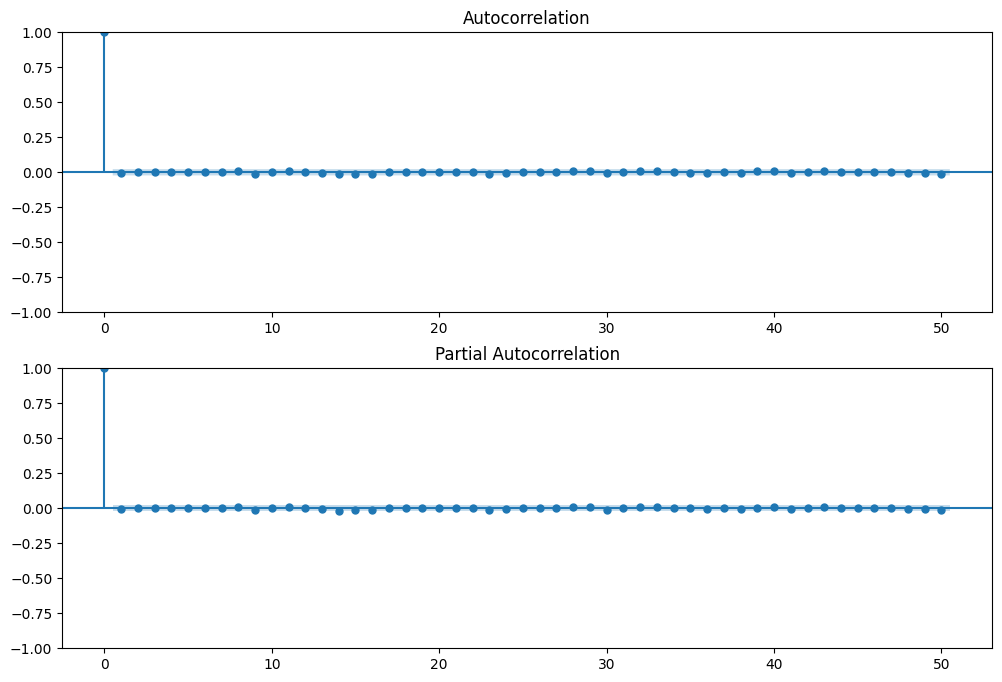

In [ ]:
# ACF and PACF of residuals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, lags=50, ax=ax[0])
plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

In [ ]:
from scipy import stats
# Ljung-Box test for autocorrelation
lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)
print('Ljung-Box Test (Residuals):')
print('Lag\tStatistic\tP-value')
for lag, stat, p_value in zip(range(1, 21), lb_test_stat, lb_test_p_value):
    if isinstance(stat, (int, float)) and isinstance(p_value, (int, float)):
        print(f'{lag}\t{stat:.2f}\t{p_value:.2f}')
    else:
        print(f'{lag}\t{stat}\t{p_value}')

# Normality test (Jarque-Bera test)
jb_test = stats.jarque_bera(residuals)
print('\nJarque-Bera Test (Residuals):')
print('JB Statistic:', jb_test[0])
print('p-value:', jb_test[1])

Ljung-Box Test (Residuals):
Lag	Statistic	P-value
1	l	l
2	b	b
3	_	_
4	s	p
5	t	v
6	a	a
7	t	l

Jarque-Bera Test (Residuals):
JB Statistic: 4221027694.520334
p-value: 0.0


In [ ]:
import plotly.graph_objects as go

In [ ]:
trace_actual = go.Scatter(x=exchange['date'], y=exchange['Ex_rate'])
trace_forecast = go.Scatter(x=exchange['date'], y=exchange['Ex_rate'])

# Show plot
fig = go.Figure(data=[trace_actual, trace_forecast])
fig.update_layout(title='Actual vs Forecasted Exchange Rate',
                   xaxis_title='Date',
                   yaxis_title='Exchange Rate')

# Show plot
fig.show()

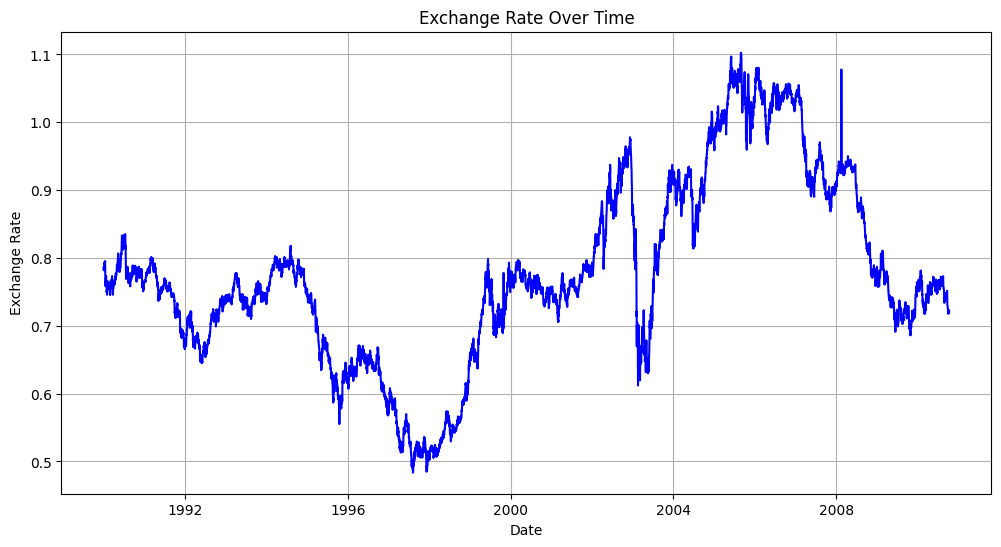

In [ ]:
# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(exchange['date'], exchange['Ex_rate'], color='blue')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

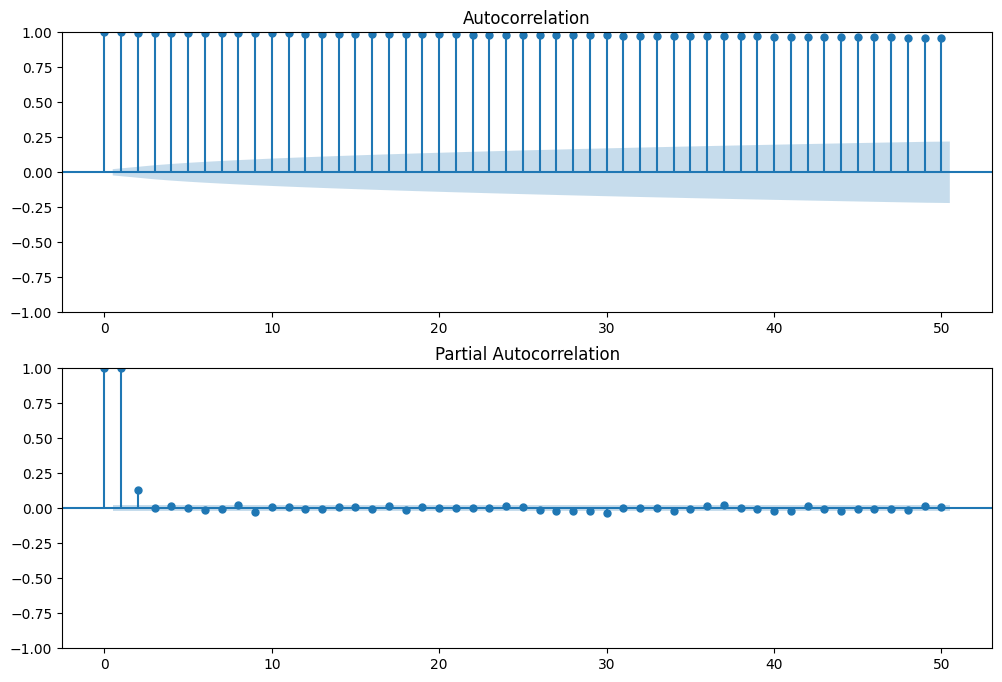

In [ ]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(exchange['Ex_rate'], lags=50, ax=ax[0])
plot_pacf(exchange['Ex_rate'], lags=50, ax=ax[1])
plt.show()

* Based on these considerations, we can choose the appropriate Exponential Smoothing model:

* If the data has no trend or seasonality, we can use the Simple Exponential Smoothing model.

* If the data has a trend but no seasonality, we can use Holt’s Linear model.

* If the data has both trend and seasonality, we should use the Holt-Winters model.

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error

In [ ]:
# Fit Simple Exponential Smoothing model
model = SimpleExpSmoothing(train_data)
model_fit = model.fit()

In [ ]:
# Make predictions
predictions = model_fit.forecast(len(test_data))

In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(test_data, predictions)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.04217124165053738


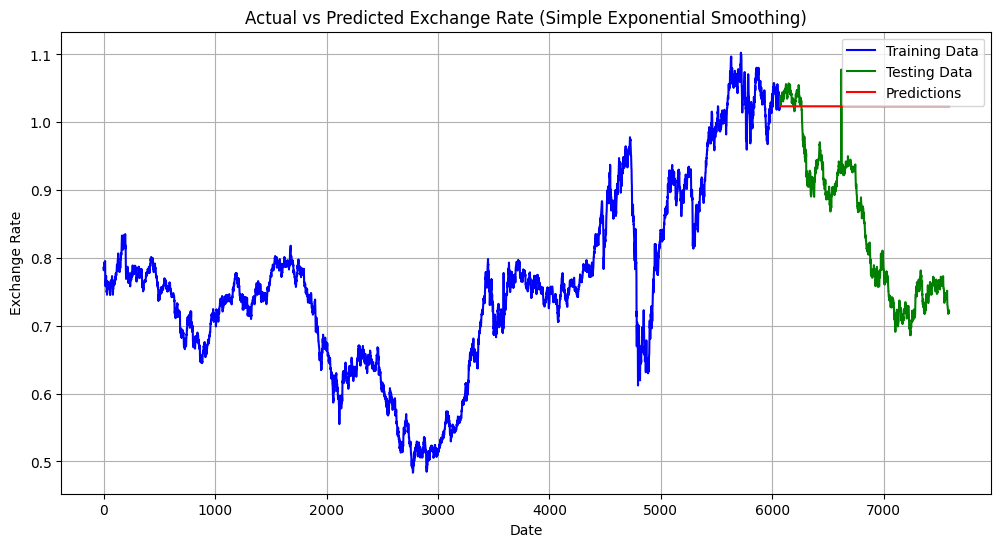

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Testing Data', color='green')
plt.plot(test_data.index, predictions, label='Predictions', color='red')
plt.title('Actual vs Predicted Exchange Rate (Simple Exponential Smoothing)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

* A MSE of 0.042 suggests that the SES model provides a reasonable fit to the data, but further evaluation and comparison with alternative models may be warranted.

In [ ]:
# Define a grid of parameters to search
alpha_values = np.arange(0.1, 1.1, 0.1)  # Smoothing level
best_mse = float('inf')
best_params = None

In [ ]:
# Perform grid search
for alpha in alpha_values:
    # Fit Simple Exponential Smoothing model with current parameter
    model = SimpleExpSmoothing(train_data)
    model_fit = model.fit(smoothing_level=alpha)

    # Make predictions
    predictions = model_fit.forecast(len(test_data))

    # Calculate Mean Squared Error
    mse = mean_squared_error(test_data, predictions)

    # Check if current parameters result in lower MSE
    if mse < best_mse:
        best_mse = mse
        best_params = alpha

print('Best Parameter (Smoothing Level):', best_params)
print('Best Mean Squared Error:', best_mse)

Best Parameter (Smoothing Level): 0.4
Best Mean Squared Error: 0.04213183157926758


* The grid search results indicate that the best parameter (smoothing level) for the Simple Exponential Smoothing (SES) model is approximately 0.4, resulting in a mean squared error (MSE) of about 0.0421.

In [ ]:
from statsmodels.tsa.holtwinters import Holt

In [ ]:
# Fit Holt's Linear trend model
model_with_trend = Holt(train_data)
model_fit_with_trend = model_with_trend.fit(smoothing_level=0.4, smoothing_trend=0.2, optimized=False)

In [ ]:
# Make predictions with the model including trend
predictions_with_trend = model_fit_with_trend.forecast(len(test_data))

In [ ]:
# Calculate MSE for the model with trend
mse_with_trend = mean_squared_error(test_data, predictions_with_trend)
print('Mean Squared Error (with trend):', mse_with_trend)

Mean Squared Error (with trend): 0.02249869721204819


* It seems like the model with Holt's Linear trend method has been successfully fitted and evaluated. The mean squared error (MSE) of the model with trend is approximately 0.0225.

In [ ]:
# Fit Holt's Linear trend model to the entire dataset
model = Holt(exchange['Ex_rate'])
model_fit = model.fit(smoothing_level=0.4, smoothing_trend=0.2, optimized=False)

In [ ]:
# Forecast future values
forecast_values = model_fit.forecast(steps=100)

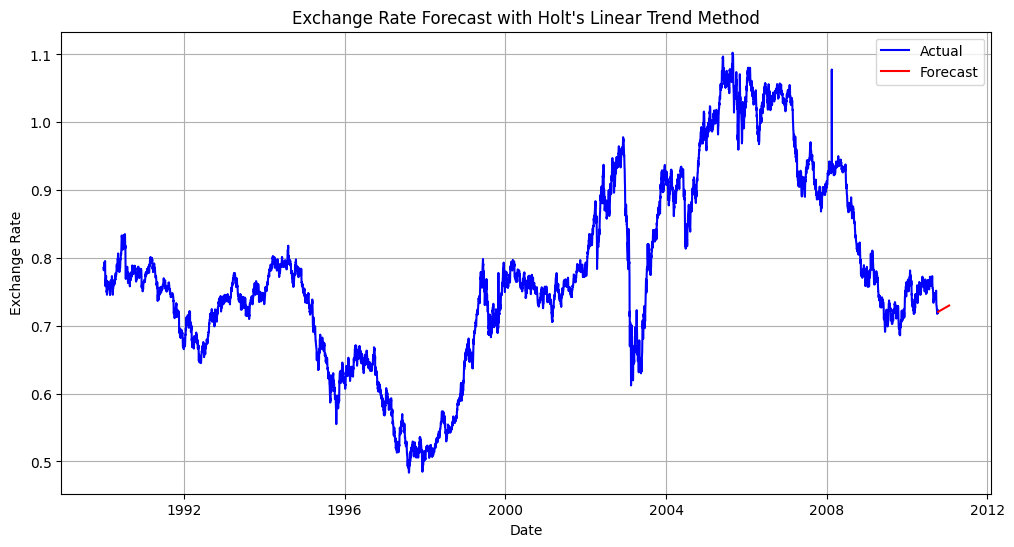

In [ ]:
# Visualize the forecasted values along with the actual data
plt.figure(figsize=(12, 6))
plt.plot(exchange['date'], exchange['Ex_rate'], label='Actual', color='blue')
plt.plot(pd.date_range(start=exchange['date'].iloc[-1], periods=101, freq='D')[1:], forecast_values, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Forecast with Holt\'s Linear Trend Method')
plt.legend()
plt.grid(True)
plt.show()

1. We fit the Holt's Linear trend model to the entire dataset.

2. We forecast future values for a specified number of steps.

3. We visualize the forecasted values along with the actual data using matplotlib.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Calculate MAE for Simple Exponential Smoothing
mae_ses = mean_absolute_error(test_data, predictions)
print('Mean Absolute Error (SES):', mae_ses)

# Calculate RMSE for Simple Exponential Smoothing
rmse_ses = np.sqrt(mean_squared_error(test_data, predictions))
print('Root Mean Squared Error (SES):', rmse_ses)

# Calculate MAPE for Simple Exponential Smoothing
mape_ses = np.mean(np.abs((test_data - predictions) / test_data)) * 100
print('Mean Absolute Percentage Error (SES):', mape_ses)

Mean Absolute Error (SES): 0.1776467417654809
Root Mean Squared Error (SES): 0.20536605071712852
Mean Absolute Percentage Error (SES): 22.78995394991468


In [ ]:
# Calculate MAE for Holt's Linear trend model
mae_holt = mean_absolute_error(test_data, predictions_with_trend)
print('Mean Absolute Error (Holt):', mae_holt)

# Calculate RMSE for Holt's Linear trend model
rmse_holt = np.sqrt(mean_squared_error(test_data, predictions_with_trend))
print('Root Mean Squared Error (Holt):', rmse_holt)

# Calculate MAPE for Holt's Linear trend model
mape_holt = np.mean(np.abs((test_data - predictions_with_trend) / test_data)) * 100
print('Mean Absolute Percentage Error (Holt):', mape_holt)

Mean Absolute Error (Holt): 0.1297685478714832
Root Mean Squared Error (Holt): 0.1499956573106308
Mean Absolute Percentage Error (Holt): 16.633292353671276


# **Model Comparison**

#Simple Exponential Smoothing (SES)
**Performance:**

MAE: 0.1776
RMSE: 0.2054
MAPE: 22.79%
SES exhibits a moderate performance, with a relatively high MAPE indicating that the model's predictions are on average 22.79% off from the actual values.

**Advantages:**

Simplicity: SES is the most straightforward forecasting method and is easy to implement.
Effectiveness for stationary data: It performs well for data without any trend or seasonality.

**Limitations:**

Inability to capture trends or seasonality: SES cannot effectively model data with time-dependent patterns.
Sensitivity to initial value: The initial value used in the smoothing equation significantly impacts the model's predictions.

# Holt's Linear Method
**Performance:**

MAE: 0.1298
RMSE: 0.1499
MAPE: 16.63%
Holt's Linear Method demonstrates improved performance compared to SES, with lower error metrics. The MAPE of 16.63% suggests that the model's predictions are generally closer to the actual values.

**Advantages:**

Handles trends: Holt's Linear Method can effectively model data with linear trends.
Flexibility: It allows for adjusting the smoothing parameters to fit different data characteristics.

**Limitations:**

**Assumes linear trends:** If the underlying trend is non-linear, Holt's Linear Method may not capture the pattern accurately.
**Cannot handle seasonality**: Similar to SES, it does not account for seasonal patterns in the data.

**Conclusion**:

Holt's Linear Method outperforms SES in terms of accuracy, especially in capturing the trend component of the data. While SES is suitable for stationary data, Holt's Linear Method is a better choice when dealing with data exhibiting linear trends.